# Triples

Created by Kidror

```
# S12 and S13: ballpark factors are just an offset of 0.045 for S12 and much of S13
# total offset thus is 0.05 (or if you do (ballpark factors - 0.5) before fitting, they fall out)
# crabitat data is miniscule, other ballparks don't exist in this data set yet (we should fix this...)
dfc["threshold"] = 0.05 + 0.20*gf - 0.04*opw - 0.06*chase + 0.025*fwd + 0.025*grand + 0.04*obt

# S14: stubborn outlier, fiddly formula. really don't like 0.199 and -0.038 for gf and opw
# dfc["threshold"] = 0.044 + 0.2*gf - 0.04*opw - 0.046*chase + 0.015*fwd + 0.0267*grand + 0.034*obt

# S15: fiddly formula
# dfc["threshold"] = 0.043 + 0.2*gf - 0.04*opw - 0.0475*chase + 0.03*fwd + 0.026*grand + 0.04*obt
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-triples.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df['gf_times_batter_vibes'] = df['batter_ground_friction'] * df['batter_vibes']
df['op_times_pitcher_vibes'] = df['pitcher_overpowerment'] * df['pitcher_vibes']

season = 12
df = df[df['season'] == season]
len(df)

3049

In [2]:
# patch the fielder multiplier, which missed Shelled when done in resim.py (last time I ran it anyway)
def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        mul += 0.50
    return mul

df["fielder_multiplier"] = df.apply(get_fielder_mul, axis=1)

In [3]:

dfc = df.copy()
for exclude_mod in ["O_NO", "ON_FIRE", "OVERPERFORMING", "UNDERPERFORMING", "GROWTH", "HIGH_PRESSURE", "SINKING_SHIP", "TRAVELING", "CHUNKY", "SMOOTH"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']

dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]
dfc = dfc[dfc["fielder_multiplier"] == 1]


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["gf_vibes"] = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
dfc["opw_vibes"] = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["unthwack_vibes"] = dfc["pitcher_unthwackability"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["chase_vibes"] = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
dfc["cold_vibes"] = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["ruth_vibes"] = dfc["pitcher_ruthlessness"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["shakes_vibes"] = dfc["pitcher_shakespearianism"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["supp_vibes"] = dfc["pitcher_suppression"] * (1 + 0.2*dfc["pitcher_vibes"])
dfc["hard"] = dfc["ballpark_forwardness"] - dfc["ballpark_viscosity"] - dfc["ballpark_ominousness"]
dfc["hit"] = dfc["ballpark_grandiosity"] + dfc["ballpark_obtuseness"] - dfc["ballpark_inconvenience"]
dfc["fwd"] = dfc["ballpark_forwardness"] - 0.5
dfc["grand"] = dfc["ballpark_grandiosity"] - 0.5
dfc["obt"] = dfc["ballpark_obtuseness"] - 0.5


X = dfc[["roll", "gf_vibes", "opw_vibes", "chase_vibes",
         "fwd", "grand", "obt",
         # "ballpark_forwardness",
         # "ballpark_viscosity",
         # "ballpark_ominousness",
         # "ballpark_grandiosity",
         # "ballpark_obtuseness",
         # "ballpark_inconvenience",
         # "ballpark_elongation",
        ]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(fit_intercept=True, dual=False, C=10000000, max_iter=10000, tol=1e-6).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[1758,    0],
       [   0,  229]])

In [5]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

1758
229


In [6]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.05046926]


[(1.0, 'roll'),
 (-0.19857705701306924, 'gf_vibes'),
 (-0.1948095106346475, 'fwd'),
 (-0.08276467398683551, 'grand'),
 (0.060187853985492396, 'chase_vibes'),
 (-0.04230453524177044, 'obt'),
 (0.038312710407710185, 'opw_vibes')]

In [7]:
gf = dfc["batter_ground_friction"] * (1 + 0.2*dfc["batter_vibes"])
opw = dfc["pitcher_overpowerment"] * (1 + 0.2*dfc["pitcher_vibes"])
grand = dfc["ballpark_grandiosity"]
vis = dfc["ballpark_viscosity"]
fwd = dfc["ballpark_forwardness"]
omi = dfc["ballpark_ominousness"]
obt = dfc["ballpark_obtuseness"]
elong = dfc["ballpark_elongation"]
chase = dfc["fielder_chasiness"] * (1 + 0.2*dfc["fielder_vibes"])
cold = dfc["pitcher_coldness"] * (1 + 0.2*dfc["pitcher_vibes"])

fwd = dfc["fwd"]
grand = dfc["grand"]
obt = dfc["obt"]

# S12 & 13: 0.05 + 0.2*gf - 0.06*chase - 0.04*opw

# dfc["threshold"] = 0.0525 + 0.2*gf - 0.045*chase - 0.0425*opw

dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

# S12 and S13: ballpark factors are just an offset of 0.045 for S12 and much of S13
# total offset thus is 0.05 (or if you do (ballpark factors - 0.5) before fitting, they fall out)
# crabitat data is miniscule, other ballparks don't exist in this data set yet (we should fix this...)
dfc["threshold"] = 0.05 + 0.20*gf - 0.04*opw - 0.06*chase + 0.025*fwd + 0.025*grand + 0.04*obt

# S14: stubborn outlier, fiddly formula. really don't like 0.199 and -0.038 for gf and opw
# dfc["threshold"] = 0.044 + 0.2*gf - 0.04*opw - 0.046*chase + 0.015*fwd + 0.0267*grand + 0.034*obt

# S15: fiddly formula
# dfc["threshold"] = 0.043 + 0.2*gf - 0.04*opw - 0.0475*chase + 0.03*fwd + 0.026*grand + 0.04*obt

[0.05046926]
(0.19857705701306924, 'gf_vibes')
(-0.038312710407710185, 'opw_vibes')
(-0.060187853985492396, 'chase_vibes')
(0.1948095106346475, 'fwd')
(0.08276467398683551, 'grand')
(0.04230453524177044, 'obt')


0


,offset,weather,event_type,roll,threshold,fielder_name,fielder_chasiness,batter_name,pitcher_name,batter_mods,pitcher_mods,fwd,grand,obt,batting_team_mods,pitching_team_mods,day,game_id,play_count


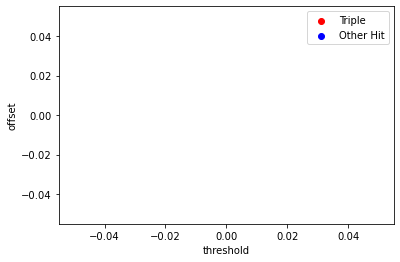

In [8]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Triple")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
print(len(table))
table[["offset", "weather", "event_type",# "batter_multiplier", "pitcher_multiplier",
       "roll", "threshold",
       "fielder_name", "fielder_chasiness",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "fwd",
         "grand",
         "obt",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


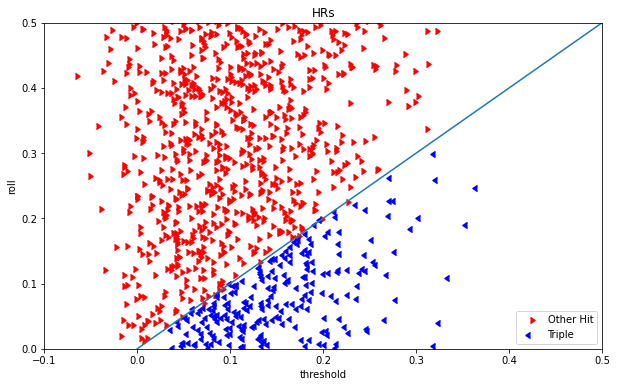

In [9]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Other Hit", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Triple", marker=CARETLEFTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("HRs")
ax.set_xlim([-0.1, 0.5])
ax.set_ylim([0.0, 0.5])
ax.legend()

In [10]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.2987399854083441
0.0125936247375799


In [11]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.0010131944243807
0.9999806574852484


In [12]:
dfc.groupby("stadium_id").size()

stadium_id
cfb57d7c-4118-4b0a-85cc-4e3a51a66cb6    40
dtype: int64